In [0]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!ls "/content/drive/My Drive/clevernewestimages/images/"

CLEVR_new_000000.png  CLEVR_new_004964.png  CLEVR_new_010075.png
CLEVR_new_000001.png  CLEVR_new_004965.png  CLEVR_new_010076.png
CLEVR_new_000002.png  CLEVR_new_004966.png  CLEVR_new_010077.png
CLEVR_new_000003.png  CLEVR_new_004967.png  CLEVR_new_010078.png
CLEVR_new_000004.png  CLEVR_new_004968.png  CLEVR_new_010079.png
CLEVR_new_000005.png  CLEVR_new_004969.png  CLEVR_new_010080.png
CLEVR_new_000006.png  CLEVR_new_004970.png  CLEVR_new_010081.png
CLEVR_new_000007.png  CLEVR_new_004971.png  CLEVR_new_010082.png
CLEVR_new_000008.png  CLEVR_new_004972.png  CLEVR_new_010083.png
CLEVR_new_000009.png  CLEVR_new_004973.png  CLEVR_new_010084.png
CLEVR_new_000010.png  CLEVR_new_004974.png  CLEVR_new_010085.png
CLEVR_new_000011.png  CLEVR_new_004975.png  CLEVR_new_010086.png
CLEVR_new_000012.png  CLEVR_new_004976.png  CLEVR_new_010087.png
CLEVR_new_000013.png  CLEVR_new_004977.png  CLEVR_new_010088.png
CLEVR_new_000014.png  CLEVR_new_004978.png  CLEVR_new_010089.png
CLEVR_new_000015.png  CLE

In [0]:
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib

import numpy as np 
import pandas as pd 
import os

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

from keras.layers import Dense, Embedding, LSTM, Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re 


Using TensorFlow backend.


In [0]:
#!pip install attention_utils
from keras.layers import dot
from keras.layers import Add
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

#from attention_utils import get_activations, get_data_recurrent

INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False


def attention_3d_block(inputs):
    #inputs.shape = (batch_size, time_steps, input_dim)
    #input_dim = int(inputs.shape[1])
    a = Permute((2 ,1))(inputs)
    #a = Reshape((32, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = dot([inputs, a_probs],axes=2)
    return output_attention_mul

In [0]:
import json
from pprint import pprint
with open('/content/drive/My Drive/Quest_Answers.json') as f:
  data=json.load(f)
  
#pprint(data)

In [0]:
data2=pd.DataFrame(data.get("quest_answers",None))

In [0]:
liss=data2['Question'].values.tolist()
[liss]
  

[['There is a metal thing that is in front of the gray thing right of the big blue shiny sphere; how many rubber cubes are in front of it?',
  'Are there any metallic spheres in front of the thing that is in front of the big thing that is on the right side of the big cyan metal object?',
  'There is a cylinder that is left of the blue metal object behind the blue object in front of the blue cylinder; how big is it?',
  'What is the shape of the blue shiny thing behind the big metal object on the left side of the shiny cylinder in front of the large gray matte block?',
  'What color is the large metallic ball that is in front of the metallic ball on the left side of the cylinder in front of the blue sphere?',
  'What is the material of the sphere to the right of the blue thing that is in front of the cylinder that is on the right side of the big cyan ball?',
  'Are there the same number of large gray matte things and cyan matte objects?',
  'Are there fewer large shiny balls than large 

In [0]:
CNN_weights_file_name   = '/content/drive/My Drive/vgg16_weights.h5'

In [0]:
num_words = 5000
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')
tokenizer.fit_on_texts(data2['Question'].values)
X = tokenizer.texts_to_sequences(data2['Question'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

max_length_of_text = 200
X = pad_sequences(X, maxlen=max_length_of_text)

Found 80 unique tokens.


In [0]:
embeddings_index = {}
f = open('/content/drive/My Drive/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_length_of_text,
                            trainable=False)

In [0]:
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)

    output = Dense(1, activation='sigmoid')(lstm_out)
    model = Model(input=[inputs], output=output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [0]:
from keras.layers import CuDNNLSTM
embed_dim = 300
lstm_out = 32
#batch_size = 32
length_of_text=200

#inputs2 = Input((length_of_text, ))
inputs2 = Input((length_of_text, ))
x2 = embedding_layer(inputs2)
x2 =  LSTM(lstm_out, return_sequences=True)(x2)
#x2 = CuDNNLSTM(lstm_out, return_sequences=False)(x2)
#x2 = Dense(512,activation='relu')(x2)
attention_mul = attention_3d_block(x2)
attention_mul = Flatten()(attention_mul)
model2 = Model(inputs2, attention_mul)
print(model2.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     24300       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 200, 32)      42624       embedding_1[2][0]                
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 32, 200)      0           lstm_5[0][0]                     
__________________________________________________________________________________________________
dense_9 (D

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D,MaxPooling2D, Activation, Dropout, BatchNormalization, Input,LeakyReLU

model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(32,32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(Conv2D(16, (3, 3)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Conv2D(64, (3, 3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))


# model.add(Dropout(0.3))

# model.add(Dense(15))
# model.add(Activation('softmax')) 

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 13, 13, 32)        0         
__________

In [0]:
from keras.layers import *

mergedOut = Concatenate()([model.output,model2.output])

In [0]:
#mergedOut = Flatten()(mergedOut)    
#mergedOut = Dense(64, activation='relu')(mergedOut)
#mergedOut = Dropout(.5)(mergedOut)

# output layer
mergedOut = Dense(24, activation='softmax')(mergedOut)

from keras.models import Model

newModel = Model([model.input,model2.input], mergedOut)

In [0]:
newModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
newModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_7_input (InputLayer)     (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 30, 30, 16)   448         conv2d_7_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 30, 30, 16)   64          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 30, 30, 16)   0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np

from keras.utils import Sequence
class CIFAR10Sequence(Sequence):

    def __init__(self, x_set,RNN_train, y_set, batch_size):
        self.x, self.x2, self.y = x_set,RNN_train, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x2= self.x2[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        temp_list=[]
        for R in batch_x2:
         #print(str(R))
         temp_list.append(R)
        
        temp_list32=[]
        for imgname in batch_x:
         #print(str(R))
          im =resize(imread(imgname), (32, 32, 3))
          #im=cv2.resize(cv2.imread(imgname), (224, 224))
          temp_list32.append(im) 
         
        temp_list3=[]
        for ans in batch_y:
          temp_list3.append(ans)
          
        return [np.array(temp_list32),np.array(temp_list)],np.array(temp_list3) 


In [0]:
from keras.utils import np_utils
PATH1 = "/content/drive/My Drive/clevernewestimages/images/"
imagge_name_list=[]
for img in data2['Image']:
  imagge_name_list.append(PATH1+img+'.png')
  
#num_classes=2 
data2['Answer'].replace('large',11,inplace=True)
data2['Answer'].replace('small',12,inplace=True)
data2['Answer'].replace('yellow',13,inplace=True)
data2['Answer'].replace('cyan',14,inplace=True)
data2['Answer'].replace('brown',15,inplace=True)
data2['Answer'].replace('gray',16,inplace=True)
data2['Answer'].replace('purple',17,inplace=True)
data2['Answer'].replace('blue',18,inplace=True)
data2['Answer'].replace('red',19,inplace=True)
data2['Answer'].replace('green',20,inplace=True)
data2['Answer'].replace('cylinder',21,inplace=True)
data2['Answer'].replace('metal',22,inplace=True)
data2['Answer'].replace('rubber',23,inplace=True)
data2['Answer'].replace('sphere',10,inplace=True)
data2['Answer'].replace('cube',9,inplace=True)
data2['Answer'].replace('True',1,inplace=True)
  
Y_train_ans=np_utils.to_categorical(data2['Answer'],24)  

In [0]:
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

newimagge_name_list,newX,newY_train_ans=shuffle(imagge_name_list,X,Y_train_ans, random_state=2)
X_train1,X_test1,X_train2, X_test2, Y_train, Y_test=train_test_split(newimagge_name_list,newX,newY_train_ans, test_size=0.3, random_state=2)


In [0]:
#!ls "/content/drive/My Drive/images/"

In [0]:
data_gen=CIFAR10Sequence(X_train1,X_train2,Y_train,128)
valid_data_gen=CIFAR10Sequence(X_test1,X_test2,Y_test,128)

history=newModel.fit_generator(data_gen,
        steps_per_epoch=len(X_train1)/128,epochs=5,validation_data=valid_data_gen,
        validation_steps=len(X_test1)/128)

Epoch 1/5


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


739/738 [==============================] - 1000s 1s/step - loss: 1.4300 - acc: 0.3853 - val_loss: 1.0479 - val_acc: 0.4281
Epoch 2/5
739/738 [==============================] - 986s 1s/step - loss: 1.0082 - acc: 0.4566 - val_loss: 1.0559 - val_acc: 0.4304
Epoch 3/5
739/738 [==============================] - 989s 1s/step - loss: 0.9845 - acc: 0.4694 - val_loss: 1.0456 - val_acc: 0.4165
Epoch 4/5
739/738 [==============================] - 988s 1s/step - loss: 0.9589 - acc: 0.4825 - val_loss: 1.0144 - val_acc: 0.4370
Epoch 5/5
739/738 [==============================] - 983s 1s/step - loss: 0.9472 - acc: 0.4942 - val_loss: 1.0012 - val_acc: 0.4581


In [0]:
newModel.save('/content/drive/My Drive/projectmodel_5epoch_LSTM.h5')

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


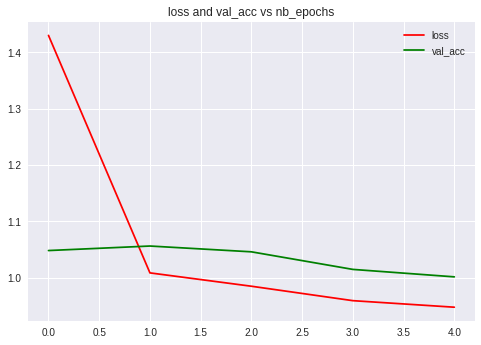

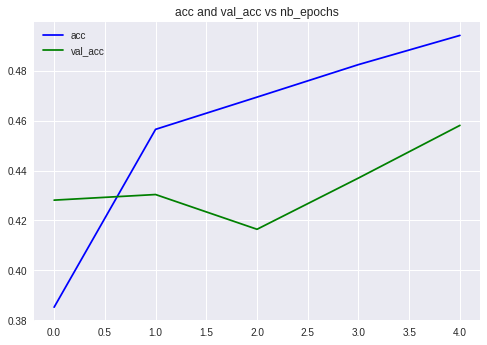

In [0]:
import matplotlib.pyplot as plt

his = newModel.history
#Plot of the validation loss (loss on testing set('g')) and loss on training set('r')
plt.figure(0)
plt.plot(his.history['loss'], 'r')
plt.plot(his.history['val_loss'], 'g')
plt.title('loss and val_acc vs nb_epochs')
plt.legend(['loss','val_acc'])

plt.figure(1)
plt.plot(his.history['acc'], 'b')
plt.plot(his.history['val_acc'], 'g')
plt.title('acc and val_acc vs nb_epochs')
plt.legend(['acc','val_acc'])